In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
from datetime import datetime, timedelta
from matplotlib.axes import Axes
import xesmf as xe
from scipy.interpolate import RegularGridInterpolator
from scipy import interpolate

/home/manmeet/anaconda3/envs/py35/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
data_dir = 'ocean_thickness.res.nc'  # daily
ds_thickness_i = xr.open_dataset(data_dir)

data_dir = 'ocean_temp_salt.res.nc'  # daily
ds_temp_salt = xr.open_dataset(data_dir)

data_dir = 'grid_spec.nc'  # daily
ds_grid_spec_720x410 = xr.open_dataset(data_dir)

data_dir = 'grid_spec_192_94_360_200.nc'  # daily
ds_grid_spec_360x200 = xr.open_dataset(data_dir)

In [3]:
ds_thickness_i_dswt = ds_thickness_i.dswt
ds_thickness_i_ = ds_thickness_i.drop('dswt').drop('zaxis_2')

In [4]:
ds_thickness_i_

<xarray.Dataset>
Dimensions:  (Time: 1, xaxis_1: 360, yaxis_1: 200, zaxis_1: 50)
Coordinates:
  * xaxis_1  (xaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * yaxis_1  (yaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 197.0 198.0 199.0 200.0
  * zaxis_1  (zaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 46.0 47.0 48.0 49.0 50.0
  * Time     (Time) float64 1.0
Data variables:
    rho_dzt  (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    dzt_dst  (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    dstlo    (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    dstup    (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    dst      (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    pbot0    (Time, yaxis_1, xaxis_1) float64 ...
Attributes:
    filename:  RESTART/18821001.000000.ocean_thickness.res.nc

In [5]:
ds_thickness_i_dswt

<xarray.DataArray 'dswt' (Time: 1, zaxis_2: 51, yaxis_1: 200, xaxis_1: 360)>
[3672000 values with dtype=float64]
Coordinates:
  * xaxis_1  (xaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * yaxis_1  (yaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 197.0 198.0 199.0 200.0
  * zaxis_2  (zaxis_2) float64 1.0 2.0 3.0 4.0 5.0 ... 47.0 48.0 49.0 50.0 51.0
  * Time     (Time) float64 1.0
Attributes:
    long_name:  dswt
    units:      none

In [6]:
ds_thickness_i_['xaxis_1'] = ds_grid_spec_360x200.gridlon_t.values
ds_thickness_i_['yaxis_1'] = ds_grid_spec_360x200.gridlat_t.values
ds_thickness_i_['zaxis_1'] = ds_grid_spec_360x200.zt.values

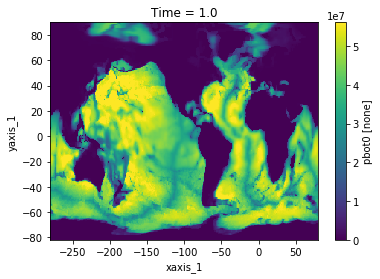

In [7]:
ds_thickness_i_.pbot0.plot()

In [8]:
zt = ds_grid_spec_360x200.zt.values
zt1 = np.zeros((zt.shape[0]+1))
zt1[0] = zt[0]/2
zt1[-1] = zt[-1] + ((zt[-1] - zt[-2])/2)
for i in range(1,zt1.shape[0]-1):
    zt1[i] = (zt[i] + zt[i-1])/2

In [67]:
zt_ = ds_grid_spec_720x410.zt.values
zt2 = np.zeros((zt_.shape[0]+1))
zt2[0] = zt_[0]/2
zt2[-1] = zt_[-1] + ((zt_[-1] - zt_[-2])/2)
for i in range(1,zt2.shape[0]-1):
    zt2[i] = (zt_[i] + zt_[i-1])/2

In [9]:
ds_thickness_i_dswt['xaxis_1'] = ds_grid_spec_360x200.gridlon_t.values
ds_thickness_i_dswt['yaxis_1'] = ds_grid_spec_360x200.gridlat_t.values
ds_thickness_i_dswt['zaxis_2'] = zt1

In [10]:
ds_thickness_i_dswt

<xarray.DataArray 'dswt' (Time: 1, zaxis_2: 51, yaxis_1: 200, xaxis_1: 360)>
[3672000 values with dtype=float64]
Coordinates:
  * xaxis_1  (xaxis_1) float32 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yaxis_1  (yaxis_1) float32 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
  * zaxis_2  (zaxis_2) float64 2.5 10.0 20.0 ... 4.769e+03 5.133e+03 5.499e+03
  * Time     (Time) float64 1.0
Attributes:
    long_name:  dswt
    units:      none

In [11]:
ds_out = xr.Dataset({'lat': (['lat'], ds_grid_spec_720x410.grid_y_T.values),
                     'lon': (['lon'], ds_grid_spec_720x410.grid_x_T.values),
                     'lev': (['lev'], ds_grid_spec_720x410.zt.values),
                    }
                   )
ds_thickness_i__ = ds_thickness_i_.rename({
  "yaxis_1": "lat",
  "xaxis_1": "lon",
  "zaxis_1": "lev"
})

In [12]:
regridder = xe.Regridder(ds_thickness_i__, ds_out, 'bilinear')

Create weight file: bilinear_200x360_410x720.nc


In [13]:
regridder.clean_weight_file()

Remove file bilinear_200x360_410x720.nc


In [14]:
ds_thickness_o = regridder(ds_thickness_i__)

using dimensions ('lat', 'lon') from data variable rho_dzt as the horizontal dimensions for this dataset.


/home/manmeet/anaconda3/envs/py35/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


In [15]:
ds_thickness_o

<xarray.Dataset>
Dimensions:  (Time: 1, lat: 410, lev: 50, lon: 720)
Coordinates:
  * lev      (lev) float32 5.0 15.0 25.0 35.0 ... 4587.7427 4950.4087 5316.4287
  * Time     (Time) float64 1.0
  * lon      (lon) float32 -279.75 -279.25 -278.75 -278.25 ... 78.75 79.25 79.75
  * lat      (lat) float32 -80.75 -80.25 -79.75 -79.25 ... 88.75 89.25 89.75
Data variables:
    rho_dzt  (Time, lev, lat, lon) float64 0.0 1.035e+04 1.035e+04 ... 0.0 0.0
    dzt_dst  (Time, lev, lat, lon) float64 0.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    dstlo    (Time, lev, lat, lon) float64 0.0 5.0 5.0 5.0 ... 0.0 0.0 0.0 0.0
    dstup    (Time, lev, lat, lon) float64 0.0 5.0 5.0 5.0 ... 0.0 0.0 0.0 0.0
    dst      (Time, lev, lat, lon) float64 0.0 10.0 10.0 10.0 ... 0.0 0.0 0.0
    pbot0    (Time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [75]:
def vinterp(field, levold, levnew):
    coords =  {'lat': field.lat.values, 'lon': field.lon.values, 'lev': levnew, 'Time': field.Time.values}
    dummy = np.zeros((field.Time.values.shape[0], levnew.shape[0], field.lat.values.shape[0], field.lon.values.shape[0]))
    field_o_ = xr.DataArray(data=dummy, coords=coords, dims=['Time', 'lev', 'lat', 'lon'])
    field_o = xr.Dataset(data_vars={"dummy": field_o_})
    for ii in field.data_vars:
        print(field[ii].name)
        if (len(field[ii].shape)==3):
            field_o[ii] = (('Time', 'lat', 'lon'),  field[ii].values)
        else:
            orig   = np.zeros((levold.shape[0], field[ii].shape[2], field[ii].shape[3]))
            interp = np.zeros((levnew.shape[0], field[ii].shape[2], field[ii].shape[3]))
            orig = field[ii].values[0,:,:,:]
            for i in range(field[ii].shape[2]):
                for j in range(field[ii].shape[3]):
                    f = interpolate.interp1d(levold, orig[:,i,j])
                    interp[:,i,j] = f(levnew)
            interp = np.expand_dims(interp, axis=0)
            field_o[ii] = (('Time', 'lev','lat', 'lon'),  interp)
    field_o = field_o.drop('dummy')
    return field_o

In [76]:
ds_thickness_o_ = vinterp(ds_thickness_o, ds_grid_spec_360x200.zt.values, ds_grid_spec_720x410.zt.values)

rho_dzt
dzt_dst
dstlo
dstup
dst
pbot0


In [77]:
ds_thickness_i.rho_dzt

<xarray.DataArray 'rho_dzt' (Time: 1, zaxis_1: 50, yaxis_1: 200, xaxis_1: 360)>
[3600000 values with dtype=float64]
Coordinates:
  * xaxis_1  (xaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * yaxis_1  (yaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 197.0 198.0 199.0 200.0
  * zaxis_1  (zaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 46.0 47.0 48.0 49.0 50.0
  * Time     (Time) float64 1.0
Attributes:
    long_name:  rho_dzt
    units:      none

In [78]:
ds_out = xr.Dataset({'lat': (['lat'], ds_grid_spec_720x410.grid_y_T.values),
                     'lon': (['lon'], ds_grid_spec_720x410.grid_x_T.values),
                     'lev': (['lev'], zt1),
                    }
                   )
ds_thickness_i_dswt_ = ds_thickness_i_dswt.rename({
  "yaxis_1": "lat",
  "xaxis_1": "lon",
  "zaxis_2": "lev"
})

In [79]:
regridder = xe.Regridder(ds_thickness_i_dswt_, ds_out, 'bilinear')

Create weight file: bilinear_200x360_410x720.nc


In [80]:
regridder.clean_weight_file()

Remove file bilinear_200x360_410x720.nc


In [81]:
ds_thickness_o_dswt = regridder(ds_thickness_i_dswt_)

/home/manmeet/anaconda3/envs/py35/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


In [82]:
ds_thickness_o_dswt_ = xr.Dataset(data_vars={"dswt": ds_thickness_o_dswt})
ds_thickness_o_dswt__ = vinterp(ds_thickness_o_dswt_, zt1, zt2)

dswt


In [89]:
ds_thickness_o_dswt = ds_thickness_o_dswt__.rename({
  "lat": "yaxis_1",
  "lon": "xaxis_1",
  "lev": "zaxis_2",
})

In [90]:
ds_thickness_o = ds_thickness_o_.rename({
  "lat": "yaxis_1",
  "lon": "xaxis_1",
  "lev": "zaxis_1",
})

In [88]:
ds_thickness_i

<xarray.Dataset>
Dimensions:  (Time: 1, xaxis_1: 360, yaxis_1: 200, zaxis_1: 50, zaxis_2: 51)
Coordinates:
  * xaxis_1  (xaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * yaxis_1  (yaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 197.0 198.0 199.0 200.0
  * zaxis_1  (zaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 46.0 47.0 48.0 49.0 50.0
  * zaxis_2  (zaxis_2) float64 1.0 2.0 3.0 4.0 5.0 ... 47.0 48.0 49.0 50.0 51.0
  * Time     (Time) float64 1.0
Data variables:
    rho_dzt  (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    dzt_dst  (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    dstlo    (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    dstup    (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    dswt     (Time, zaxis_2, yaxis_1, xaxis_1) float64 ...
    dst      (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    pbot0    (Time, yaxis_1, xaxis_1) float64 ...
Attributes:
    filename:  RESTART/18821001.000000.ocean_thickness.res.nc

In [91]:
ds_thickness_o

<xarray.Dataset>
Dimensions:  (Time: 1, xaxis_1: 720, yaxis_1: 410, zaxis_1: 40)
Coordinates:
  * yaxis_1  (yaxis_1) float32 -80.75 -80.25 -79.75 -79.25 ... 88.75 89.25 89.75
  * xaxis_1  (xaxis_1) float32 -279.75 -279.25 -278.75 ... 78.75 79.25 79.75
  * zaxis_1  (zaxis_1) float32 5.0 15.0 25.0 35.0 ... 3483.029 3972.294 4478.478
  * Time     (Time) float64 1.0
Data variables:
    rho_dzt  (Time, zaxis_1, yaxis_1, xaxis_1) float64 0.0 1.035e+04 ... 0.0 0.0
    dzt_dst  (Time, zaxis_1, yaxis_1, xaxis_1) float64 0.0 1.0 1.0 ... 0.0 0.0
    dstlo    (Time, zaxis_1, yaxis_1, xaxis_1) float64 0.0 5.0 5.0 ... 0.0 0.0
    dstup    (Time, zaxis_1, yaxis_1, xaxis_1) float64 0.0 5.0 5.0 ... 0.0 0.0
    dst      (Time, zaxis_1, yaxis_1, xaxis_1) float64 0.0 10.0 10.0 ... 0.0 0.0
    pbot0    (Time, yaxis_1, xaxis_1) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [92]:
ds_thickness_o_dswt

<xarray.Dataset>
Dimensions:  (Time: 1, xaxis_1: 720, yaxis_1: 410, zaxis_2: 41)
Coordinates:
  * yaxis_1  (yaxis_1) float32 -80.75 -80.25 -79.75 -79.25 ... 88.75 89.25 89.75
  * xaxis_1  (xaxis_1) float32 -279.75 -279.25 -278.75 ... 78.75 79.25 79.75
  * zaxis_2  (zaxis_2) float64 2.5 10.0 20.0 ... 3.728e+03 4.225e+03 4.732e+03
  * Time     (Time) float64 1.0
Data variables:
    dswt     (Time, zaxis_2, yaxis_1, xaxis_1) float64 0.0 5.0 5.0 ... 0.0 0.0

In [94]:
ds_thickness_o = xr.merge([ds_thickness_o, ds_thickness_o_dswt])

In [146]:
ds_thickness_i.Time

<xarray.DataArray 'Time' (Time: 1)>
array([1.])
Coordinates:
  * Time     (Time) float64 1.0
Attributes:
    long_name:       Time
    units:           time level
    cartesian_axis:  T

In [144]:
x = ds_thickness_o.xaxis_1.values
ds_thickness_o['xaxis_1'] = np.arange(x.shape[0], dtype=np.double)

y = ds_thickness_o.yaxis_1.values
ds_thickness_o['yaxis_1'] = np.arange(y.shape[0], dtype=np.double)

z = ds_thickness_o.zaxis_1.values
ds_thickness_o['zaxis_1'] = np.arange(z.shape[0], dtype=np.double)

z1 = ds_thickness_o.zaxis_2.values
ds_thickness_o['zaxis_2'] = np.arange(z1.shape[0], dtype=np.double)

ds_thickness_o.xaxis_1.attrs['long_name'] = 'xaxis_1'
ds_thickness_o.xaxis_1.attrs['units'] = 'xaxis_1'
ds_thickness_o.xaxis_1.attrs['cartesian_axis'] = 'X'

ds_thickness_o.yaxis_1.attrs['long_name'] = 'yaxis_1'
ds_thickness_o.yaxis_1.attrs['units'] = 'yaxis_1'
ds_thickness_o.yaxis_1.attrs['cartesian_axis'] = 'Y'

ds_thickness_o.zaxis_1.attrs['long_name'] = 'zaxis_1'
ds_thickness_o.zaxis_1.attrs['units'] = 'zaxis_1'
ds_thickness_o.zaxis_1.attrs['cartesian_axis'] = 'Z'

ds_thickness_o.zaxis_2.attrs['long_name'] = 'zaxis_2'
ds_thickness_o.zaxis_2.attrs['units'] = 'zaxis_2'
ds_thickness_o.zaxis_2.attrs['cartesian_axis'] = 'Z'

ds_thickness_o.rho_dzt.attrs['long_name'] = 'rho_dzt'
ds_thickness_o.rho_dzt.attrs['units'] = 'none'

ds_thickness_o.dzt_dst.attrs['long_name'] = 'dzt_dst'
ds_thickness_o.dzt_dst.attrs['units'] = 'none'

ds_thickness_o.dstlo.attrs['long_name'] = 'dstlo'
ds_thickness_o.dstlo.attrs['units'] = 'none'

ds_thickness_o.dstup.attrs['long_name'] = 'dstup'
ds_thickness_o.dstup.attrs['units'] = 'none'

ds_thickness_o.dst.attrs['long_name'] = 'dst'
ds_thickness_o.dst.attrs['units'] = 'none'

ds_thickness_o.pbot0.attrs['long_name'] = 'pbot0'
ds_thickness_o.pbot0.attrs['units'] = 'none'

ds_thickness_o.dswt.attrs['long_name'] = 'dswt'
ds_thickness_o.dswt.attrs['units'] = 'none'

In [148]:
ds_thickness_o.to_netcdf('ocean_thickness.res.regrid.nc')